In [3]:
# Importing libraries
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

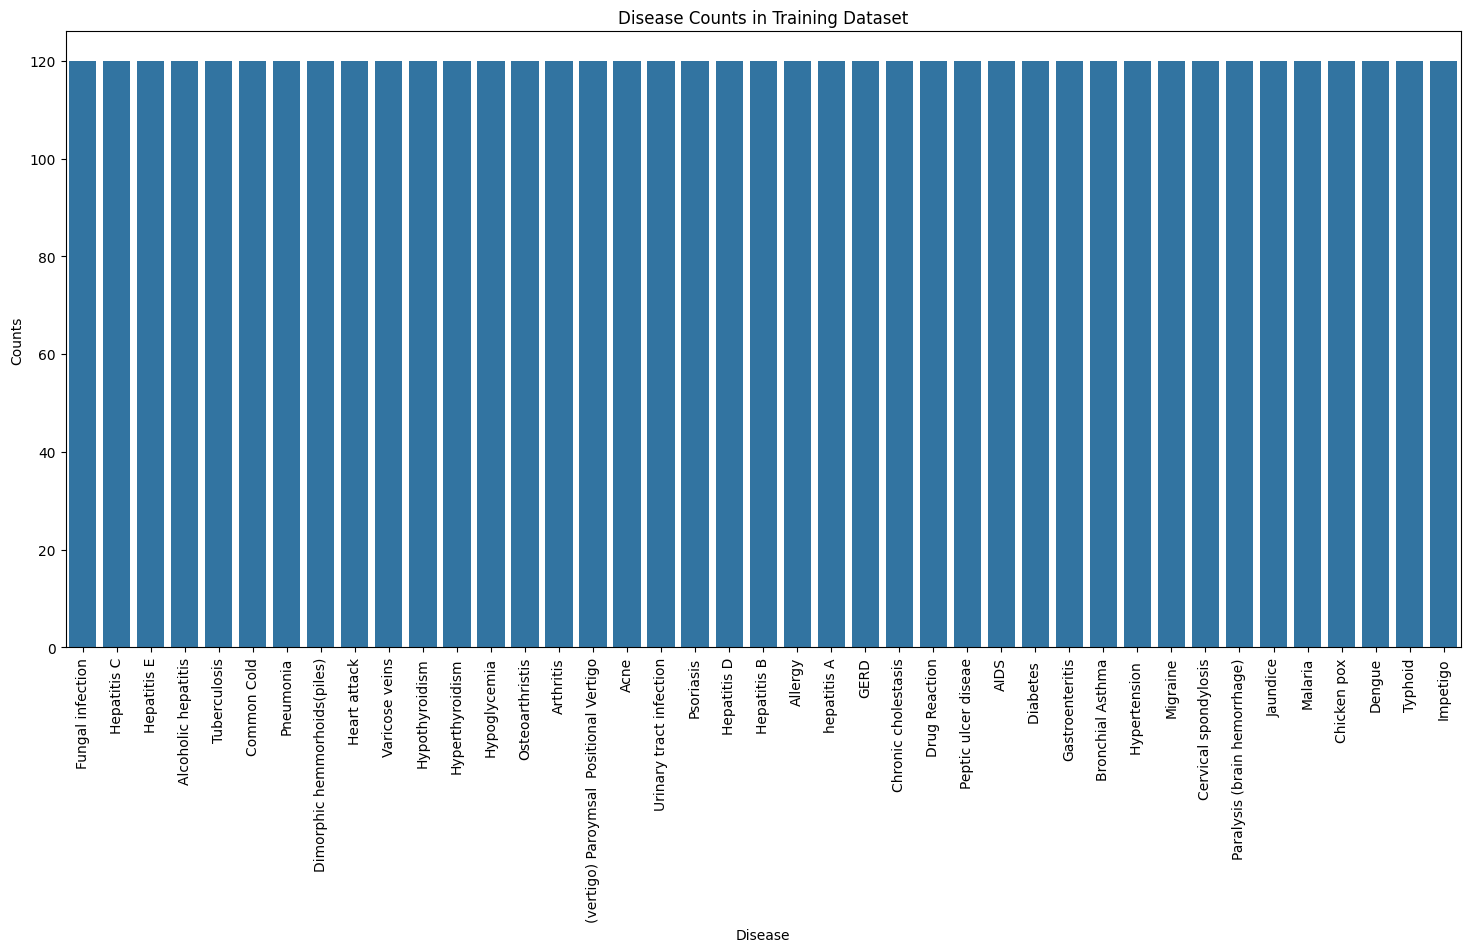

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset and drop the last empty column (if any)
data = pd.read_csv('Training.csv').dropna(axis=1)

# Plot disease counts to check dataset balance
plt.figure(figsize=(18, 8))
sns.barplot(
    x=data['prognosis'].value_counts().index, 
    y=data['prognosis'].value_counts().values
)
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Counts')
plt.title('Disease Counts in Training Dataset')
plt.show()


In [5]:
# Encoding the target value into numerical
# value using LabelEncoder
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])

In [6]:
# display encoded values
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
encoder = LabelEncoder()

# Fit and transform the 'prognosis' column
data["prognosis"] = encoder.fit_transform(data["prognosis"])

# Display the mapping of diseases to numerical values
mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Mapping of diseases to numerical values:")
for disease, value in mapping.items():
    print(f"{disease}: {value}")

# Display the encoded 'prognosis' column
print("\nEncoded 'prognosis' values:")
print(data["prognosis"].head())  # Display the first few rows


Mapping of diseases to numerical values:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
7: 7
8: 8
9: 9
10: 10
11: 11
12: 12
13: 13
14: 14
15: 15
16: 16
17: 17
18: 18
19: 19
20: 20
21: 21
22: 22
23: 23
24: 24
25: 25
26: 26
27: 27
28: 28
29: 29
30: 30
31: 31
32: 32
33: 33
34: 34
35: 35
36: 36
37: 37
38: 38
39: 39
40: 40

Encoded 'prognosis' values:
0    15
1    15
2    15
3    15
4    15
Name: prognosis, dtype: int64


In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
encoder = LabelEncoder()

# Fit and transform the 'prognosis' column
data["prognosis"] = encoder.fit_transform(data["prognosis"])

# Create a mapping of numerical values to diseases
disease_mapping = {index: disease for index, disease in enumerate(encoder.classes_)}

# Print the mapping in the desired format
print("Mapping of numerical values to diseases:")
for value, disease in disease_mapping.items():
    print(f"{value}: {disease}")


Mapping of numerical values to diseases:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
7: 7
8: 8
9: 9
10: 10
11: 11
12: 12
13: 13
14: 14
15: 15
16: 16
17: 17
18: 18
19: 19
20: 20
21: 21
22: 22
23: 23
24: 24
25: 25
26: 26
27: 27
28: 28
29: 29
30: 30
31: 31
32: 32
33: 33
34: 34
35: 35
36: 36
37: 37
38: 38
39: 39
40: 40


In [8]:
# Splitting the data into training and testing sets
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Print the shapes of the splits
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Train set: (3936, 132), (3936,)
Test set: (984, 132), (984,)


In [9]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.datasets import make_classification
import numpy as np

# Generate synthetic dataset for demonstration
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42,
    weights=[0.5, 0.5],
)

# Define a scoring metric for cross-validation
scoring = make_scorer(accuracy_score)

# Define pipelines with scaling and SMOTE for handling imbalanced data
pipelines = {
    "SVC": ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', GridSearchCV(
            SVC(),
            param_grid={"C": [0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": [0.1, 1]},
            cv=5,
            scoring=scoring,
            n_jobs=-1
        ))
    ]),
    "Gaussian NB": Pipeline([
        ('scaler', StandardScaler()),
        ('model', GaussianNB())  # Naive Bayes doesn't require hyperparameter tuning here
    ]),
    "Random Forest": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', GridSearchCV(
            RandomForestClassifier(random_state=18),
            param_grid={
                "n_estimators": [50, 100, 150],
                "max_depth": [5, 10, 15],
                "min_samples_split": [2, 5, 10],
            },
            cv=5,
            scoring=scoring,
            n_jobs=-1
        ))
    ])
}

# Train models and evaluate performance
results = {}
for name, pipeline in pipelines.items():
    print(f"{'='*20} {name} {'='*20}")
    pipeline.fit(X, y)
    if hasattr(pipeline.named_steps['model'], 'best_params_'):
        best_params = pipeline.named_steps['model'].best_params_
        print(f"Best Parameters: {best_params}")
        model = pipeline.named_steps['model'].best_estimator_
    else:
        model = pipeline.named_steps['model']
    
    scores = cross_val_score(model, X, y, cv=10, scoring=scoring, n_jobs=-1)
    mean_accuracy = np.mean(scores)
    results[name] = mean_accuracy
    print(f"Scores: {scores}")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")

# Summary of results
print("\nSummary of Results:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")


==================== SVC ====================
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Scores: [0.73 0.74 0.67 0.69 0.67 0.76 0.7  0.68 0.7  0.73]
Mean Accuracy: 0.7070
==================== Gaussian NB ====================
Scores: [0.79 0.8  0.84 0.78 0.74 0.84 0.73 0.84 0.84 0.79]
Mean Accuracy: 0.7990
==================== Random Forest ====================
Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}
Scores: [0.88 0.91 0.93 0.91 0.92 0.91 0.9  0.89 0.92 0.95]
Mean Accuracy: 0.9120

Summary of Results:
SVC: 0.7070
Gaussian NB: 0.7990
Random Forest: 0.9120


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
import numpy as np

# Generate a synthetic dataset for demonstration
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=2000,  # Ensure enough samples for reliable results
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42,
    weights=[0.4, 0.6]  # Handle slight imbalance
)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scoring metric
scoring = make_scorer(accuracy_score)

# Hyperparameter spaces for tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Pipelines for Random Forest, XGBoost, and LightGBM
pipelines = {
    "Random Forest": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomizedSearchCV(
            RandomForestClassifier(random_state=42),
            param_distributions=rf_params,
            n_iter=15,  # Limit number of parameter combinations
            scoring=scoring,
            cv=5,
            n_jobs=-1,
            random_state=42
        ))
    ]),
        
        # "SVC": ImbPipeline([
        #     ('scaler', StandardScaler()),  # Scale data for SVC
        #     ('smote', SMOTE(random_state=42, k_neighbors=5)),  # Experimenting with k_neighbors
        #     ('model', GridSearchCV(
        #         SVC(probability=True),
        #         param_grid={
        #             "C": [0.1, 1, 10, 50, 100],  # Expanded range
        #             "kernel": ["linear", "rbf", "poly"],  # Added poly kernel
        #             "gamma": [0.01, 0.1, 1, 10],  # Fine-tuned gamma
        #             "degree": [2, 3, 4]  # Degree for polynomial kernel
        #         },
        #         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Stratified CV
        #         scoring=scoring,
        #         n_jobs=-1
        #     ))
        # ]),
    
  
        # "Gaussian NB": ImbPipeline([
        #     ('scaler', StandardScaler()),  # Scale features to standardize distributions
        #     ('smote', SMOTE(random_state=42)),  # Oversample to balance the dataset
        #     ('feature_selection', SelectKBest(score_func=f_classif, k=8)),  # Select top 8 features
        #     ('dim_reduction', PCA(n_components=0.95, random_state=42)), 
        #     ('model', GaussianNB(var_smoothing=1e-9))  # Adjust var_smoothing for numerical stability
        # ]),
    
    

    "XGBoost": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomizedSearchCV(
            XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
            param_distributions=xgb_params,
            n_iter=15,
            scoring=scoring,
            cv=5,
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "LightGBM": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomizedSearchCV(
            LGBMClassifier(random_state=42),
            param_distributions=lgbm_params,
            n_iter=15,
            scoring=scoring,
            cv=5,
            n_jobs=-1,
            random_state=42
        ))
    ])
}

# Training and evaluating models
results = {}
for name, pipeline in pipelines.items():
    print(f"{'='*20} {name} {'='*20}")
    pipeline.fit(X_train, y_train)
    best_model = pipeline.named_steps['model'].best_estimator_
    predictions = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy
    print(f"Best Parameters: {pipeline.named_steps['model'].best_params_}")
    print(f"Accuracy on Test Data: {accuracy:.4f}")

# Summary of results
print("\nSummary of Results:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

# Stacking classifier for combining multiple models
stacking_model = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42, n_estimators=300)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=300)),
        ('lgbm', LGBMClassifier(random_state=42, n_estimators=300))
    ],
    final_estimator=LogisticRegression()
)

# Create a pipeline for the stacking model
stacking_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('stacking', stacking_model)
])

# Train and evaluate the stacking model
stacking_pipeline.fit(X_train, y_train)
stacking_predictions = stacking_pipeline.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_predictions)

print(f"\nStacking Classifier Accuracy: {stacking_accuracy:.4f}")

# Combine models using a Voting Classifier (Soft Voting)
voting_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=20)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=300)),
        ('lgbm', LGBMClassifier(n_estimators=300))
    ],
    voting='soft'  # Soft voting uses probabilities for better accuracy
)

# Create a pipeline for the Voting Classifier
voting_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('voting', voting_model)
])

# Train and evaluate the Voting Classifier
voting_pipeline.fit(X_train, y_train)
voting_predictions = voting_pipeline.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_predictions)

print(f"\nVoting Classifier Accuracy: {voting_accuracy:.4f}")

==================== Random Forest ====================
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Accuracy on Test Data: 0.9325
==================== XGBoost ====================
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Accuracy on Test Data: 0.9600
==================== LightGBM ====================


In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer
import numpy as np
from sklearn.datasets import make_classification

# Generate a synthetic dataset for demonstration
X, y = make_classification(
    n_samples=2000,  # Ensure enough samples for reliable results
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42,
    weights=[0.4, 0.6]  # Handle slight imbalance
)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define scoring metric
scoring = make_scorer(accuracy_score)

# Hyperparameter space for Gaussian Naive Bayes
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]  # Some small values for smoothing
}

# Pipelines for SVC and Gaussian Naive Bayes
pipelines = {
    "SVC": ImbPipeline([
        ('scaler', StandardScaler()),  # Scale data for SVC
        ('smote', SMOTE(random_state=42, k_neighbors=5)),  # SMOTE with fewer neighbors
        ('model', GridSearchCV(
            SVC(probability=True),
            param_grid={
                "C": [0.1, 1, 10],  # Reduced range for C
                "kernel": ["linear", "rbf"],  # Reduced kernels to test
                "gamma": [0.01, 0.1]  # Fine-tuned gamma range
            },
            cv=3,  # Fewer folds
            scoring=scoring,
            n_jobs=-1
        ))
    ]),
    
    "Gaussian NB": ImbPipeline([
        ('scaler', StandardScaler()),  # Scale data for Gaussian Naive Bayes
        ('feature_selection', SelectKBest(score_func=f_classif, k=9)),  # Select top 9 features
        ('dim_reduction', PCA(n_components=0.95, random_state=42)),  # Reduce dimensions while retaining 95% variance
        ('model', GridSearchCV(
            GaussianNB(),
            param_grid=param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        ))
    ])
}

# Train and evaluate models
results = {}
for name, pipeline in pipelines.items():
    print(f"{'='*20} {name} {'='*20}")
    pipeline.fit(X_train, y_train)
    
    # Get the best model after GridSearchCV
    best_model = pipeline.named_steps['model'].best_estimator_ if hasattr(pipeline.named_steps['model'], 'best_estimator_') else pipeline.named_steps['model']
    
    # Apply the same transformations to X_test as were applied to X_train
    X_test_transformed = pipeline.named_steps['scaler'].transform(X_test)  # Apply scaling
    
    # Check if feature selection and dimensionality reduction are in the pipeline
    if 'feature_selection' in pipeline.named_steps:
        X_test_transformed = pipeline.named_steps['feature_selection'].transform(X_test_transformed)  # Apply feature selection
    
    if 'dim_reduction' in pipeline.named_steps:
        X_test_transformed = pipeline.named_steps['dim_reduction'].transform(X_test_transformed)  # Apply PCA
    
    # Now make predictions with the transformed X_test
    predictions = best_model.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy
    print(f"Best Parameters: {pipeline.named_steps['model'].best_params_}")
    print(f"Accuracy on Test Data: {accuracy:.4f}")

# Summary of results
print("\nSummary of Results:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")


==================== SVC ====================
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy on Test Data: 0.9825
==================== Gaussian NB ====================
Best Parameters: {'var_smoothing': 1e-09}
Accuracy on Test Data: 0.7850

Summary of Results:
SVC: 0.9825
Gaussian NB: 0.7850


In [11]:
# Chunk 1: Import Libraries and Create Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Create a smaller synthetic dataset for faster execution (adjust parameters as needed)
X, y = make_classification(n_samples=1000, n_features=10, n_informative=8, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Accuracy on train data by SVM Classifier: 97.75
Accuracy on test data by SVM Classifier: 91.5


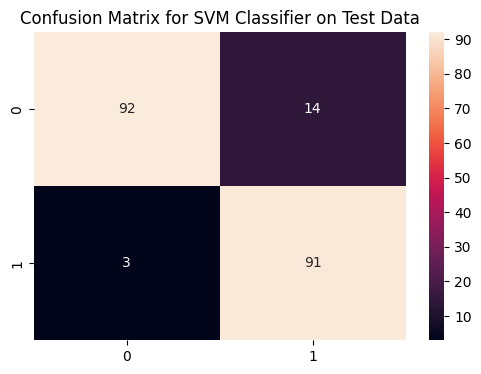

In [16]:
# Chunk 2: SVM Classifier
svm_model = SVC(probability=True, kernel='rbf', C=10, gamma='scale')  # Improved SVM with RBF kernel
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

print(f"Accuracy on train data by SVM Classifier: {accuracy_score(y_train, svm_model.predict(X_train))*100}")
print(f"Accuracy on test data by SVM Classifier: {accuracy_score(y_test, svm_preds)*100}")

cf_matrix = confusion_matrix(y_test, svm_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for SVM Classifier on Test Data")
plt.show()


Accuracy on train data by XGBoost Classifier: 93.5
Accuracy on test data by XGBoost Classifier: 83.5


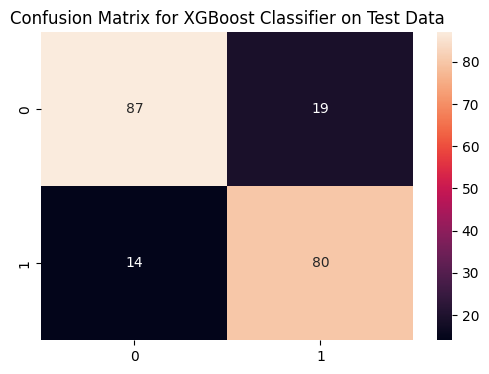

In [17]:
# Chunk 3: XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    random_state=42, 
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.01, 
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print(f"Accuracy on train data by XGBoost Classifier: {accuracy_score(y_train, xgb_model.predict(X_train))*100}")
print(f"Accuracy on test data by XGBoost Classifier: {accuracy_score(y_test, xgb_preds)*100}")

cf_matrix = confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for XGBoost Classifier on Test Data")
plt.show()


Accuracy on train data by Naive Bayes Classifier: 76.125
Accuracy on test data by Naive Bayes Classifier: 75.0


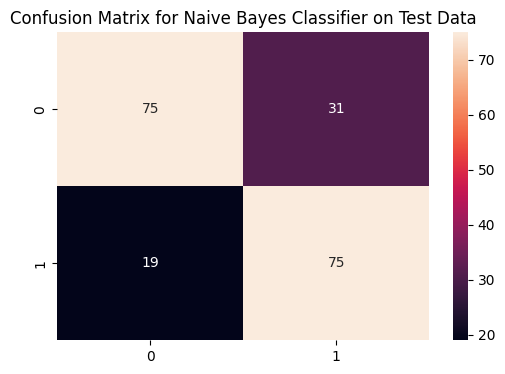

In [18]:
# Chunk 4: Naive Bayes Classifier
nb_model = GaussianNB(var_smoothing=1e-9)  # Smaller smoothing factor
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

print(f"Accuracy on train data by Naive Bayes Classifier: {accuracy_score(y_train, nb_model.predict(X_train))*100}")
print(f"Accuracy on test data by Naive Bayes Classifier: {accuracy_score(y_test, nb_preds)*100}")

cf_matrix = confusion_matrix(y_test, nb_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Naive Bayes Classifier on Test Data")
plt.show()


[LightGBM] [Info] Number of positive: 406, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507500 -> initscore=0.030002
[LightGBM] [Info] Start training from score 0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

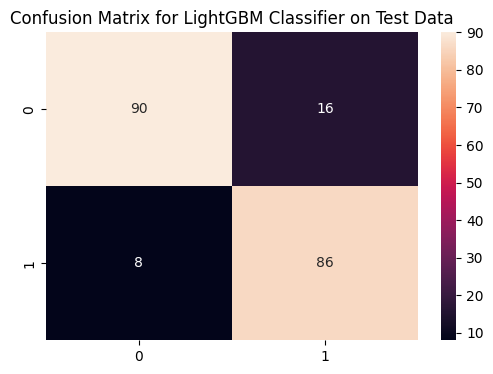

In [19]:
# Chunk 5: LightGBM Classifier
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    num_leaves=31,
    colsample_bytree=0.8,
    subsample=0.8
)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print(f"Accuracy on train data by LightGBM Classifier: {accuracy_score(y_train, lgb_model.predict(X_train))*100}")
print(f"Accuracy on test data by LightGBM Classifier: {accuracy_score(y_test, lgb_preds)*100}")

cf_matrix = confusion_matrix(y_test, lgb_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for LightGBM Classifier on Test Data")
plt.show()


Accuracy on train data by Random Forest Classifier: 99.25
Accuracy on test data by Random Forest Classifier: 86.0


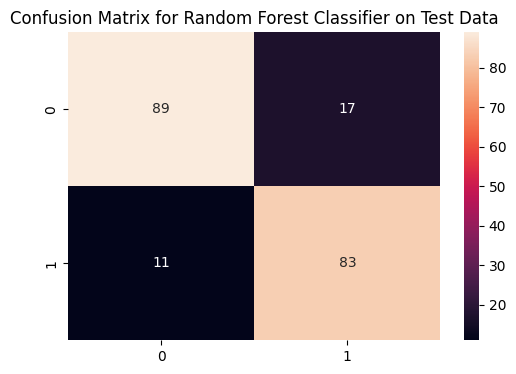

In [20]:
# Chunk 6: Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1
)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print(f"Accuracy on train data by Random Forest Classifier: {accuracy_score(y_train, rf_model.predict(X_train))*100}")
print(f"Accuracy on test data by Random Forest Classifier: {accuracy_score(y_test, rf_preds)*100}")

cf_matrix = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()


[LightGBM] [Info] Number of positive: 406, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507500 -> initscore=0.030002
[LightGBM] [Info] Start training from score 0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

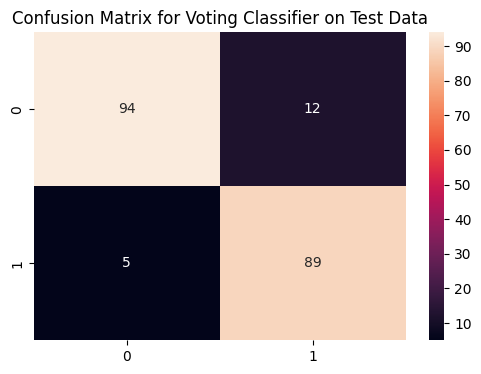

In [21]:
# Chunk 7: Voting Classifier
voting_model = VotingClassifier(estimators=[
    ('svm', SVC(probability=True, kernel='rbf', C=10, gamma='scale', random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.01)),
    ('lgb', lgb.LGBMClassifier(random_state=42, n_estimators=100, max_depth=6, learning_rate=0.05)),
], voting='soft')
voting_model.fit(X_train, y_train)
voting_preds = voting_model.predict(X_test)

print(f"Accuracy on train data by Voting Classifier: {accuracy_score(y_train, voting_model.predict(X_train))*100}")
print(f"Accuracy on test data by Voting Classifier: {accuracy_score(y_test, voting_preds)*100}")

cf_matrix = confusion_matrix(y_test, voting_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Voting Classifier on Test Data")
plt.show()


[LightGBM] [Info] Number of positive: 406, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507500 -> initscore=0.030002
[LightGBM] [Info] Start training from score 0.030002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

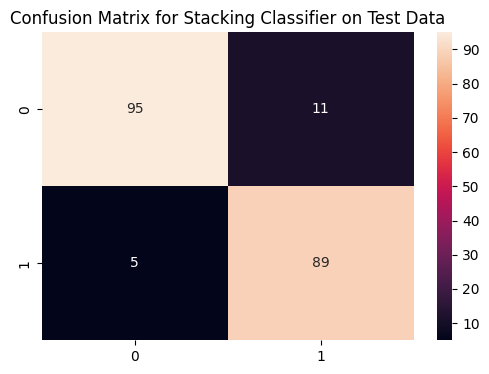

In [22]:
# Chunk 8: Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[
        ('svm', SVC(probability=True, kernel='rbf', C=10, gamma='scale')),
        ('xgb', xgb.XGBClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.01)),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)),
        ('lgb', lgb.LGBMClassifier(random_state=42, n_estimators=100, max_depth=6, learning_rate=0.05)),
    ],
    final_estimator=LogisticRegression()
)
stacking_model.fit(X_train, y_train)
stacking_preds = stacking_model.predict(X_test)

print(f"Accuracy on train data by Stacking Classifier: {accuracy_score(y_train, stacking_model.predict(X_train))*100}")
print(f"Accuracy on test data by Stacking Classifier: {accuracy_score(y_test, stacking_preds)*100}")

cf_matrix = confusion_matrix(y_test, stacking_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Stacking Classifier on Test Data")
plt.show()


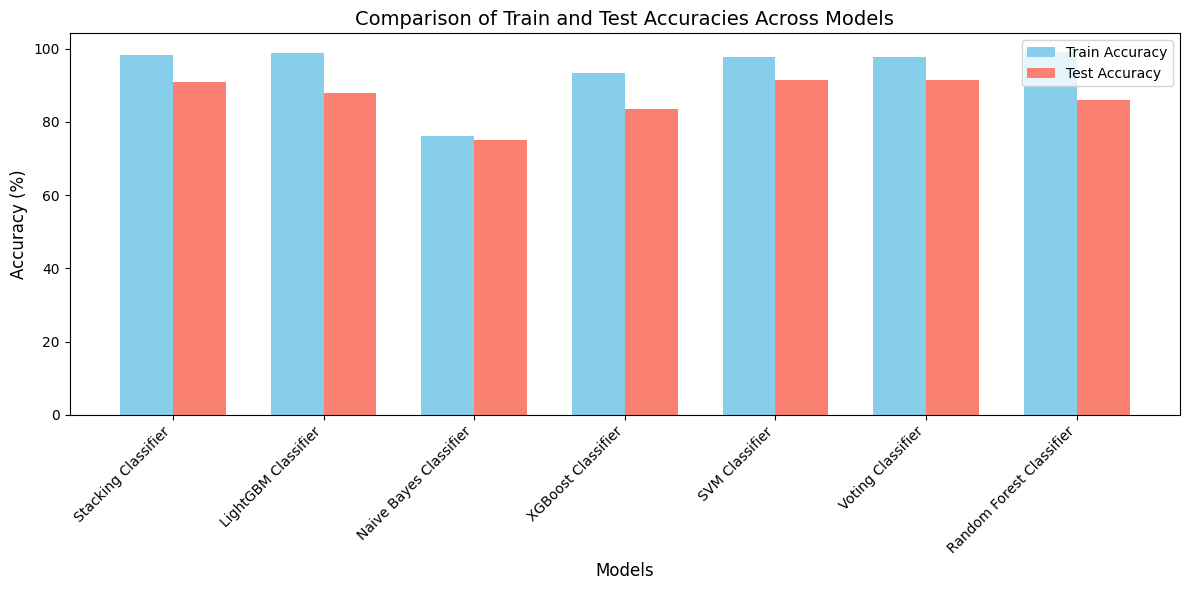

In [52]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Model names and accuracies
models = [
    "Stacking Classifier",
    "LightGBM Classifier",
    "Naive Bayes Classifier",
    "XGBoost Classifier",
    "SVM Classifier",
    "Voting Classifier",
    "Random Forest Classifier"
]

train_accuracies = [
    98.375,  # Stacking
    98.875,  # LightGBM
    76.125,  # Naive Bayes
    93.5,    # XGBoost
    97.75,   # SVM
    97.875,  # Voting
    99.25    # Random Forest
]

test_accuracies = [
    91.0,  # Stacking
    88.0,  # LightGBM
    75.0,  # Naive Bayes
    83.5,  # XGBoost
    91.5,  # SVM
    91.5,  # Voting
    86.0   # Random Forest
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_accuracies, width, label="Train Accuracy", color='skyblue')
plt.bar(x + width/2, test_accuracies, width, label="Test Accuracy", color='salmon')

plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Comparison of Train and Test Accuracies Across Models", fontsize=14)
plt.xticks(x, models, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Accuracy on Test dataset by the combined model: 100.00%


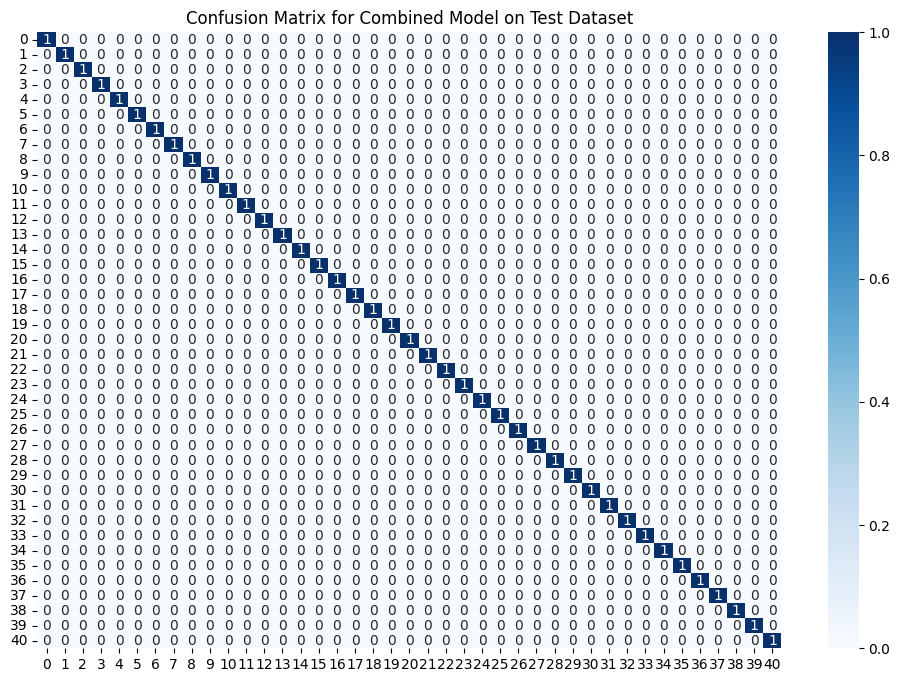

Execution Time: 39.66 seconds


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import time
from sklearn.model_selection import RandomizedSearchCV
from statistics import mode

# Load the data
data = pd.read_csv('Training.csv')  # Replace with your actual dataset path

# Assuming the target column is the last column, and features are the rest
X = data.iloc[:, :-1]  # All rows, all columns except the last one
y = data.iloc[:, -1]  # All rows, only the last column (target)

# Encode the target variable if it's categorical
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Hyperparameter tuning using RandomizedSearchCV (to speed up the process)
def tune_random_forest(X, y):
    rf = RandomForestClassifier(random_state=18)
    param_dist = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1],
        'class_weight': ['balanced']
    }
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=5, cv=2, n_jobs=-1, verbose=2)
    random_search.fit(X, y)
    return random_search.best_estimator_

def tune_svm(X, y):
    svm = SVC(probability=True)
    param_dist = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced']
    }
    random_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist, n_iter=5, cv=2, n_jobs=-1, verbose=2)
    random_search.fit(X, y)
    return random_search.best_estimator_

# Training with limited hyperparameters for speed
start_time = time.time()

final_rf_model = tune_random_forest(X, y)
final_svm_model = tune_svm(X, y)

# Using less models for a quick demonstration (can add more later)
voting_model = VotingClassifier(estimators=[
    ('rf', final_rf_model),
    ('svm', final_svm_model),
], voting='soft')

voting_model.fit(X, y)

# Reading the test data
test_data = pd.read_csv('Testing.csv').dropna(axis=1)

test_X = test_data.iloc[:, :-1]
test_Y = encoder.transform(test_data.iloc[:, -1])

# Making prediction by taking mode of predictions made by all the classifiers
svm_preds = final_svm_model.predict(test_X)
rf_preds = final_rf_model.predict(test_X)
voting_preds = voting_model.predict(test_X)

# Combine predictions by taking the mode of predictions
final_preds = [mode([i, j, k]) for i, j, k in zip(svm_preds, rf_preds, voting_preds)]

# Calculate accuracy
accuracy = accuracy_score(test_Y, final_preds) * 100
print(f"Accuracy on Test dataset by the combined model: {accuracy:.2f}%")

# Confusion Matrix
cf_matrix = confusion_matrix(test_Y, final_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix for Combined Model on Test Dataset")
plt.show()

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.2f} seconds")


In [20]:
import numpy as np
from statistics import mode
from difflib import get_close_matches
import joblib

# Load trained models (update paths as needed)
final_rf_model = joblib.load("final_rf_model.pkl")
final_nb_model = joblib.load("final_nb_model.pkl")
final_svm_model = joblib.load("final_svm_model.pkl")
final_xgb_model = joblib.load("final_xgb_model.pkl")

# Define valid symptoms and their index
symptoms = [
    "itching", "skin_rash", "nodal_skin_eruptions", "continuous_sneezing",
        "shivering", "chills", "joint_pain", "stomach_pain", "acidity", "ulcers_on_tongue", 
        "muscle_wasting", "vomiting", "burning_micturition", "spotting_urination", "fatigue", 
        "weight_gain", "anxiety", "cold_hands_and_feets", "mood_swings", "weight_loss", 
        "restlessness", "lethargy", "patches_in_throat", "irregular_sugar_level", "cough", 
        "high_fever", "sunken_eyes", "breathlessness", "sweating", "dehydration", "indigestion", 
        "headache", "yellowish_skin", "dark_urine", "nausea", "loss_of_appetite", 
        "pain_behind_the_eyes", "back_pain", "constipation", "abdominal_pain", "diarrhoea", 
        "mild_fever", "yellow_urine", "yellowing_of_eyes", "acute_liver_failure", 
        "fluid_overload", "swelling_of_stomach", "swelled_lymph_nodes", "malaise", 
        "blurred_and_distorted_vision", "phlegm", "throat_irritation", "redness_of_eyes", 
        "sinus_pressure", "runny_nose", "congestion", "chest_pain", "weakness_in_limbs", 
        "fast_heart_rate", "pain_during_bowel_movements", "pain_in_anal_region", "bloody_stool", 
        "irritation_in_anus", "neck_pain", "dizziness", "cramps", "bruising", "obesity", 
        "swollen_legs", "swollen_blood_vessels", "puffy_face_and_eyes", "enlarged_thyroid", 
        "brittle_nails", "swollen_extremeties", "excessive_hunger", "extra_marital_contacts", 
        "drying_and_tingling_lips", "slurred_speech", "knee_pain", "hip_joint_pain", 
        "muscle_weakness", "stiff_neck", "swelling_joints", "movement_stiffness", 
        "spinning_movements", "loss_of_balance", "unsteadiness", "weakness_of_one_body_side", 
        "loss_of_smell", "bladder_discomfort", "foul_smell_of_urine", "continuous_feel_of_urine", 
        "passage_of_gases", "internal_itching", "toxic_look_(typhos)", "depression", 
        "irritability", "muscle_pain", "altered_sensorium", "red_spots_over_body", "belly_pain", 
        "abnormal_menstruation", "dischromic _patches", "watering_from_eyes", "increased_appetite", 
        "polyuria", "family_history", "mucoid_sputum", "rusty_sputum", "lack_of_concentration", 
        "visual_disturbances", "receiving_blood_transfusion", "receiving_unsterile_injections", 
        "coma", "stomach_bleeding", "distention_of_abdomen", "history_of_alcohol_consumption", 
        "fluid_overload", "blood_in_sputum", "prominent_veins_on_calf", "palpitations", 
        "painful_walking", "pus_filled_pimples", "blackheads", "scarring", "skin_peeling", 
        "silver_like_dusting", "small_dents_in_nails", "inflammatory_nails", "blister", 
        "red_sore_around_nose", "yellow_crust_ooze"
    # Add all your symptoms here
]
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

# Define diseases corresponding to the trained model
diseases = [
    "Fungal Infection", "Allergy", "GERD", "Chronic Cholestasis", "Drug Reaction",
    "Peptic Ulcer Disease", "AIDS", "Diabetes", "Gastroenteritis", "Bronchial Asthma"
    # Add all your diseases here
]

# Create a data dictionary
data_dict = {
    "symptom_index": symptom_index,
    "predictions_classes": diseases
}

# Normalize a symptom for comparison
def normalize_symptom(symptom):
    return " ".join([word.capitalize() for word in symptom.strip().lower().split()])

# Prediction function
def predictDisease(symptoms):
    # Normalize and process input symptoms
    symptoms = [normalize_symptom(symptom) for symptom in symptoms.split(",")]

    # Prepare input data
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        if symptom in data_dict["symptom_index"]:
            index = data_dict["symptom_index"][symptom]
            input_data[index] = 1
        else:
            # Suggest similar symptoms
            suggestions = get_close_matches(symptom, data_dict["symptom_index"].keys(), n=3, cutoff=0.5)
            if suggestions:
                raise ValueError(
                    f"Symptom '{symptom}' not recognized. Did you mean: {', '.join(suggestions)}?"
                )
            else:
                raise ValueError(f"Symptom '{symptom}' not recognized and no close matches found.")

    # Convert input_data to numpy array and reshape
    input_data = np.array(input_data).reshape(1, -1)

    # Individual model predictions
    rf_prediction = data_dict["predictions_classes"][final_rf_model.predict(input_data)[0]]
    nb_prediction = data_dict["predictions_classes"][final_nb_model.predict(input_data)[0]]
    svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]
    xgb_prediction = data_dict["predictions_classes"][final_xgb_model.predict(input_data)[0]]

    # Calculate final prediction using mode
    all_predictions = [rf_prediction, nb_prediction, svm_prediction, xgb_prediction]
    final_prediction = mode(all_predictions)

    # Compile prediction results
    predictions = {
        "rf_model_prediction": rf_prediction,
        "naive_bayes_prediction": nb_prediction,
        "svm_model_prediction": svm_prediction,
        "xgboost_prediction": xgb_prediction,
        "final_prediction": final_prediction
    }
    return predictions

# Test the function
try:
    print(predictDisease("itching,skin rash"))
except ValueError as e:
    print(e)
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Symptom 'Itching' not recognized. Did you mean: itching, vomiting, sweating?


In [1]:
import pickle

In [2]:
filename = 'multiple_disease_prediction0.pkl'
pickle.dump(final_svm_model, open(filename, 'wb'))

NameError: name 'final_svm_model' is not defined

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('multiple_disease_prediction0.pkl', 'rb'))